# Pipeline for High-z Radio Galaxies 24: Redshift prediction (high z, new instance with data balancing)

## Introduction

Training for regression (prediction) of redshift for sources in the HETDEX field. 

Sources are all elements detected in the CatWISE2020 catalogue. But regression  
will be done only with AGN from the Million Quasar Catalog (MQC).  
Only sources with confirmed $z$ will be used.

Also, as a test, only high-redshift sources ($z \geq 3.6$ (or $3.7$), from recall behaviour. Turn-off point) will be used.  
Additionally, SMOGN will be used to increase the parameter space size oversampling highest redshift elements.

Being either AGN or galaxy will not be used as an additional feature.

Training data is from HETDEX Spring Field.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import numpy as np
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import mpl_scatter_density
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.visualization import LogStretch, PowerStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
# from sklearn.metrics import ConfusionMatrixDisplay, roc_auc_score, roc_curve, RocCurveDisplay, matthews_corrcoef
# from sklearn.calibration import calibration_curve
import sklearn.pipeline
import ppscore as pps
import seaborn as sns
import colorcet as cc
# from pycaret import classification as pyc
from pycaret import regression as pyr
from pycaret.internal.tabular import _get_columns_to_stratify_by
import pandas as pd
import smogn

In [2]:
mpl.rcdefaults()

Create class to normalize asymmetric colorscales  
(from [http://chris35wills.github.io/matplotlib_diverging_colorbar/](http://chris35wills.github.io/matplotlib_diverging_colorbar/)).

In [3]:
class MidpointNormalize(mcolors.Normalize):
    """
    Normalise the colorbar so that diverging bars work there way either side from a prescribed midpoint value)

    e.g. im=ax1.imshow(array, norm=MidpointNormalize(midpoint=0.,vmin=-100, vmax=100))
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        mcolors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y), np.isnan(value))

For future plots, we can configure their aspect too.

In [4]:
cmap           = cm.get_cmap('inferno')
cmap_alt       = cm.get_cmap('Dark2')
cmap_alt_2     = cm.get_cmap('Greys_r')  # Shades of grey
cmap_alt_3     = cm.get_cmap('coolwarm')  # blue to red
dark_color     = cmap(0.4)  # RGBA color code
light_color    = cmap(0.6)  # RGBA color code
colors         = [cmap(0.15), cmap(0.30), cmap(0.45), cmap(0.60), cmap(0.75), cmap(0.90)]
colors_3       = [cmap(0.25), cmap(0.50), cmap(0.75)]
colors_3_alt   = [cmap_alt(0.25), cmap_alt(0.50), cmap_alt(0.75)]
colors_3_alt_2 = [cmap_alt_2(0.25), cmap_alt_2(0.50), cmap_alt_2(0.75)]
colors_8       = [cmap(0.12), cmap(0.24), cmap(0.35), cmap(0.48), cmap(0.6), cmap(0.72), cmap(0.84), cmap(0.96)]
colors_8_alt   = [cmap_alt(0.12), cmap_alt(0.24), cmap_alt(0.35), cmap_alt(0.48), cmap_alt(0.6), cmap_alt(0.72),\
                  cmap_alt(0.84), cmap_alt(0.96)]
colors_8_alt_2 = [cmap_alt_2(0.06), cmap_alt_2(0.18), cmap_alt_2(0.29), cmap_alt_2(0.42), cmap_alt_2(0.54),\
                  cmap_alt_2(0.66), cmap_alt_2(0.78), cmap_alt_2(0.90)]
colors_8_alt_3 = [cmap_alt_3(0.06), cmap_alt_3(0.18), cmap_alt_3(0.29), cmap_alt_3(0.42), cmap_alt_3(0.54),\
                  cmap_alt_3(0.66), cmap_alt_3(0.78), cmap_alt_3(0.90)]

In [5]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

alp_str        = r'$\alpha$'

Define specific metrics for redshift values:  

$$
\sigma_{\mathrm{NMAD}} = 1.48 \times \mathrm{median}\left(\frac{|(z_{True} - z_{Predict})|}{(1 + z_{True})}\right)
$$

In [6]:
def sigma_mad(z_true, z_pred, **kwargs):
    med = np.nanmedian(np.abs(z_true - z_pred)).astype('float32')
    return 1.48 * med

In [7]:
def sigma_nmad(z_true, z_pred, **kwargs):
    dif  = (z_true - z_pred)
    frac = dif / (1 + z_true).values
    med  = np.nanmedian(np.abs(frac)).astype('float32')
    return 1.48 * med

In [8]:
def sigma_z(z_true, z_pred, **kwargs):
    dif = z_true - z_pred
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [9]:
def sigma_z_norm(z_true, z_pred, **kwargs):
    dif = (z_true - z_pred) / (1 + z_true)
    ssq = np.sum(dif**2)
    rot = np.sqrt(ssq / len(z_true)).astype('float32')
    return rot

In [10]:
def outlier_frac(z_true, z_pred, **kwargs):
    dif  = np.abs((z_true - z_pred) / (1 + z_true))
    siz  = np.sum(np.isfinite(dif)).astype('float32')
    num  = np.sum(np.array(dif > 0.15)).astype('float32')
    frac = num / siz
    return frac

Methdods for PyCaret and saved models.

In [11]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()

In [12]:
def get_feature_importances_df(pycaret_pipeline, sample_df, n = 10):
    
    final_cols = get_final_column_names(pycaret_pipeline, sample_df)
    
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        try:
            variables = pycaret_pipeline["trained_model"].feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline["trained_model"].estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    else:
        try:
            variables = pycaret_pipeline.feature_importances_
            
        except:
            variables = np.mean([
                            tree.feature_importances_ for tree in pycaret_pipeline.estimators_
                if hasattr(tree, 'feature_importances_')
                            ], axis=0)
        
        coef_df = pd.DataFrame({'Feature': final_cols, 'Importance': variables})
        sorted_df = (
            coef_df.sort_values(by='Importance', ascending=False)
            .head(n)
            .sort_values(by='Importance', ascending=True).reset_index(drop=True)
        )
    return sorted_df

In [13]:
def plot_conf_mat(confusion_matrix, title, axin, display_labels=['Non true', 'True'], cmap='cet_dimgray_r', show_clb=False, log_stretch=False):
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix,
                              display_labels=display_labels)

    min_val_colour = np.nanmin(confusion_matrix)
    max_val_colour = np.nanmin(confusion_matrix)
    
    if log_stretch:
        norm = ImageNormalize(stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize()

    # NOTE: Fill all variables here with default values of the plot_confusion_matrix
    disp_b = disp.plot(include_values=True, cmap=cm.get_cmap(cmap),\
             ax=axin, xticks_rotation='horizontal')

    for text_val in disp_b.text_.flatten():
        text_val.set_fontsize(30)
    clb = plt.gca().images[-1].colorbar
    clb.ax.tick_params(labelsize=14)
    clb.ax.ticklabel_format(style='sci', scilimits=(0, 0))
    clb.outline.set_linewidth(2.5)
    clb.ax.set_ylabel('Elements in bin', size=14)
    if not show_clb:
        clb.remove()

    # disp_b.im_.set_clim(1e2, 3e3)
    disp_b.im_.norm = norm

    axin.xaxis.get_label().set_fontsize(16)
    axin.yaxis.get_label().set_fontsize(16)

    axin.tick_params(axis='both', which='major', labelsize=14)

    plt.setp(axin.spines.values(), linewidth=2.5)
    plt.setp(axin.spines.values(), linewidth=2.5)
    axin.set_title(title)
    plt.tight_layout()

In [14]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

Method to compare and plot redshifts.

In [15]:
def plot_redshift_compare(true_z, predicted_z, ax_pre, title=None, dpi=10, cmap='cet_linear_kryw_5_100_c64_r', show_clb=False, log_stretch=False):
    if log_stretch:
        norm = ImageNormalize(vmin=0., stretch=LogStretch())
    if not log_stretch:
        norm = ImageNormalize(vmin=0., stretch=PowerStretch(0.3))

    filt_pair_z   = np.isfinite(true_z) & np.isfinite(predicted_z)
    max_for_range = np.nanmax([np.nanmax(1 + true_z.loc[filt_pair_z]), np.nanmax(1 + predicted_z.loc[filt_pair_z])])
    min_for_range = np.nanmin([np.nanmin(1 + true_z.loc[filt_pair_z]), np.nanmin(1 + predicted_z.loc[filt_pair_z])])

    dens_1 = ax_pre.scatter_density((1 + true_z.sample(frac=1, random_state=seed)),\
            (1 + predicted_z.sample(frac=1, random_state=seed)),\
            cmap=plt.get_cmap(cmap), zorder=0, dpi=dpi, norm=norm, alpha=0.93)
    
    ax_pre.axline((2., 2.), (3., 3.), ls='--', marker=None, c='Gray', alpha=0.8, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 1.15), xy2=(2., 2.3), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)
    ax_pre.axline(xy1=(1., 0.85), xy2=(2., 1.7), ls='-.', marker=None, c='slateblue', alpha=0.6, lw=3.0, zorder=20)

    if show_clb:
        clb = plt.colorbar(dens_1, extend='neither', norm=norm, ticks=ticker.MaxNLocator(integer=True))
        clb.ax.tick_params(labelsize=14)
        clb.outline.set_linewidth(2.5)
        clb.ax.set_ylabel('Elements per pixel', size=16, path_effects=pe2)

    # Inset axis with residuals
    axins = inset_axes(ax_pre, width='35%', height='20%', loc=2)
    res_z_z = (predicted_z - true_z) / (1 + true_z)
    axins.hist(res_z_z, histtype='stepfilled', fc='grey', ec='k', bins=50, lw=2.5)
    axins.axvline(x=np.nanpercentile(res_z_z, [15.9]), ls='--', lw=2.5, c='royalblue')
    axins.axvline(x=np.nanpercentile(res_z_z, [84.1]), ls='--', lw=2.5, c='royalblue')
    axins.set_xlabel('$\Delta z / (1 + z_{\mathrm{True}})$', fontsize=10)
    axins.tick_params(labelleft=False, labelbottom=True)
    axins.tick_params(which='both', top=True, right=True, direction='in')
    axins.tick_params(axis='both', which='major', labelsize=10)
    axins.tick_params(which='major', length=8, width=1.5)
    axins.tick_params(which='minor', length=4, width=1.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    plt.setp(axins.spines.values(), linewidth=2.5)
    axins.set_xlim(left=-0.9, right=0.9)
    ##
    ax_pre.set_xlabel('$1 + z_{\mathrm{True}}$', fontsize=20)
    ax_pre.set_ylabel('$1 + z_{\mathrm{Predicted}}$', fontsize=20)
    ax_pre.tick_params(which='both', top=True, right=True, direction='in')
    ax_pre.tick_params(axis='both', which='minor', labelsize=14)
    ax_pre.tick_params(which='major', length=8, width=1.5)
    ax_pre.tick_params(which='minor', length=4, width=1.5)
    # ax_pre.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax_pre.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    ax_pre.xaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    ax_pre.yaxis.set_minor_formatter(ticker.ScalarFormatter(useMathText=False))
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    plt.setp(ax_pre.spines.values(), linewidth=2.5)
    ax_pre.set_xlim(left=np.floor(min_for_range), right=np.ceil(max_for_range))
    ax_pre.set_ylim(bottom=np.floor(min_for_range), top=np.ceil(max_for_range))
    ax_pre.set_title(title, fontsize=14)
    plt.tight_layout()

***

## Reading data

In [16]:
cat_path = '../../Catalogs/'  # relative path to the same directory

We import our data using the `pandas` package.

In [146]:
save_plot_flag  = False
save_model_flag = False
load_model_flag = True

/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/rcarvajal/.miniforge3/envs/test_pycaret/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int

In [18]:
use_5sigma = True  # use files with 5-sigma magnitude imputation

In [19]:
mqc_version = '7_4d'  # '7_2'

In [20]:
file_name_train = f'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_{mqc_version}_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'  # 6729647 objects (6.7e6)

First, open the file as astropy Table to modify (and standardise)  
the units of fluxes and/or magnitudes.

---

Create `pandas` DataFrame from `astropy` table.

In [21]:
features_2_discard = ['objID', 'RA_ICRS', 'DE_ICRS', 'Name', 'RA_MILLI', 'DEC_MILLI', 'TYPE',\
                      'X_ray_detect', 'Total_flux_VLASS', 'Sint_LOFAR', 'Stotal_TGSS', 'FEP',\
                      'TotalFlux_LoLSS', 'W1mag', 'W2mag', 'FUVmag', 'NUVmag'] # , 'mode',\
                     # 'class', 'f_zsp', 'subCl', 'zph', 'e_zph']  # Not needed for training in this model

In [22]:
full_catalog_df = pd.read_hdf(cat_path + file_name_train, key='df').drop(columns=features_2_discard)

In [23]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

Combine redshift values (AGN + galaxies).

In [25]:
idx_non_Z                = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

---

## Random seed

In [29]:
seed = 42

Create target

In [30]:
full_catalog_df.loc[:, 'radio_detect'] = full_catalog_df.loc[:, 'radio_detect'].astype(int)

## Split data: Test, Train, Validation

Create same train/test/validation sub-sets as with AGN/galaxy model.  
After this, select sources needed for this model (`is_AGN == 1` and `radio_detect == 1`).

In [31]:
filter_known_spec  = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
filter_known_radio = full_catalog_df.loc[:, 'radio_detect'] == 1
full_catalog_df    = full_catalog_df.loc[filter_known_spec]
train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                    random_state=seed, stratify=full_catalog_df.loc[:, 'is_AGN'])
train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                    random_state=seed, stratify=train_test_df.loc[:, 'is_AGN'])
print('Shape of used data in HETDEX')
print('(Confirmed galaxies and AGN)')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)
print()

Shape of used data in HETDEX
(Confirmed galaxies and AGN)
--------------------------------------------------
Full confirmed dataset size:        (83409, 87)
Data for Modeling (Train and Test): (66727, 87)
Training data:                      (46708, 87)
Testing data:                       (20019, 87)
Validation data:                    (16682, 87)
--------------------------------------------------



In [32]:
full_catalog_df = full_catalog_df.loc[(full_catalog_df.loc[:, 'is_AGN'] == 1) & (full_catalog_df.loc[:, 'radio_detect'] == 1)]
train_test_df   = train_test_df.loc[(train_test_df.loc[:, 'is_AGN'] == 1) & (train_test_df.loc[:, 'radio_detect'] == 1)]
train_df        = train_df.loc[(train_df.loc[:, 'is_AGN'] == 1) & (train_df.loc[:, 'radio_detect'] == 1)]
test_df         = test_df.loc[(test_df.loc[:, 'is_AGN'] == 1) & (test_df.loc[:, 'radio_detect'] == 1)]
validation_df   = validation_df.loc[(validation_df.loc[:, 'is_AGN'] == 1) & (validation_df.loc[:, 'radio_detect'] == 1)]

#### Select high-z objects

In [ ]:
redshift_low_lim = 3.6  # 3.6, 3.7, 4.0
filter_high_z    = full_catalog_df.loc[:, 'Z'] >= redshift_low_lim
full_catalog_df  = full_catalog_df.loc[full_catalog_df.loc[:, 'Z'] >= redshift_low_lim]
train_test_df    = train_test_df.loc[train_test_df.loc[:, 'Z'] >= redshift_low_lim]
train_df         = train_df.loc[train_df.loc[:, 'Z'] >= redshift_low_lim]
test_df          = test_df.loc[test_df.loc[:, 'Z'] >= redshift_low_lim]
validation_df    = validation_df.loc[validation_df.loc[:, 'Z'] >= redshift_low_lim]

In [33]:
n_is_AGN = np.sum(full_catalog_df.loc[:, 'is_AGN'] == 1)
n_is_rad = np.sum(full_catalog_df.loc[:, 'radio_detect'] == 1)
print(f'In this dataset (HETDEX), with {len(full_catalog_df.loc[:, "is_AGN"]):,} elements,\n' +\
         f'{n_is_AGN:,} of them are marked as AGN, and, from them, {n_is_rad:,} have confirmed radio detection.')

In this dataset (HETDEX), with 8,518 elements,
8,518 of them are marked as AGN, and, from them, 8,518 have confirmed radio detection.


#### Remove intermediate targets

In [34]:
full_catalog_df = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
train_test_df   = train_test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
train_df        = train_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
test_df         = test_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])
validation_df   = validation_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'is_str', 'spCl', 'radio_detect', 'zsp'])

---

In [35]:
print('Final shape of used data')
print('-' * 50)
print('Confirmed Radio AGN')
print('-' * 50)
print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
print(f'Training data:                      {train_df.shape}')
print(f'Testing data:                       {test_df.shape}')
print(f'Validation data:                    {validation_df.shape}')
print('-' * 50)

Final shape of used data
--------------------------------------------------
Confirmed Radio AGN
--------------------------------------------------
Full confirmed dataset size:        (8518, 80)
Data for Modeling (Train and Test): (6856, 80)
Training data:                      (4814, 80)
Testing data:                       (2042, 80)
Validation data:                    (1662, 80)
--------------------------------------------------


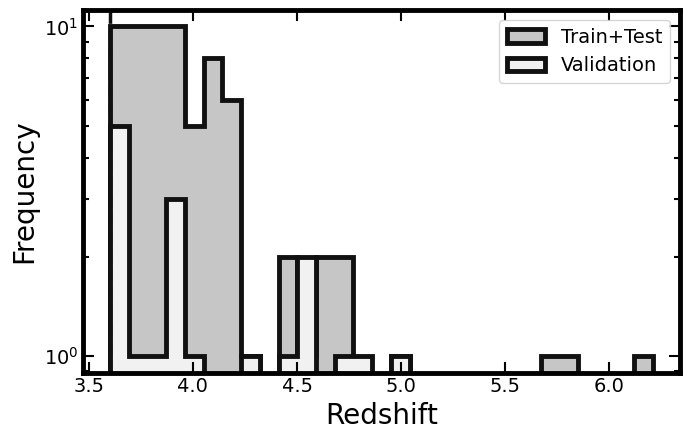

In [37]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 30)

ax1.hist(train_test_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=1.0, label='Train+Test')
ax1.hist(validation_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='Validation')

ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

Save indices of sources in validation sub-set for future steps.

In [38]:
# val_idx = validation_df.index.to_numpy()
# np.savetxt(fname='idx_validation_radio_01.txt', X=val_idx, header='Indices from first radio detection training.', fmt='%i')

---

## Use SMOGN for data augmentation at high redshifts

In [39]:
backup_train_df = train_df.copy()

In [40]:
train_df = smogn.smoter(
    
    ## main arguments
    data          = train_test_df.reset_index(drop=True),           ## pandas dataframe
    y             = 'Z',          ## string ('header name')
    k             = 10,                    ## positive integer (k < n), 4
    samp_method   = 'extreme',  ## string ('balance' or 'extreme')
    drop_na_col   = False,
    drop_na_row   = False,
    under_samp    = True,
    seed          = seed,
    replace       = False,

    ## phi relevance arguments
    rel_thres     = 0.85,         ## positive real number (0 < R < 1), 0.5
    rel_method    = 'auto',      ## string ('auto' or 'manual')
    rel_xtrm_type = 'both',   ## string ('low' or 'both' or 'high')
    rel_coef      = 2.00           ## positive real number (0 < R), 2.85
)

synth_matrix: 100%|###############################| 9/9 [00:00<00:00, 17.82it/s]


In [41]:
print('Shape of new used data (after SMOGN)')
print('-' * 40)
print(f'Data for Modeling (Train and Test): {train_df.shape}')
print('-' * 40)

Shape of new used data (after SMOGN)
----------------------------------------
Data for Modeling (Train and Test): (119, 39)
----------------------------------------


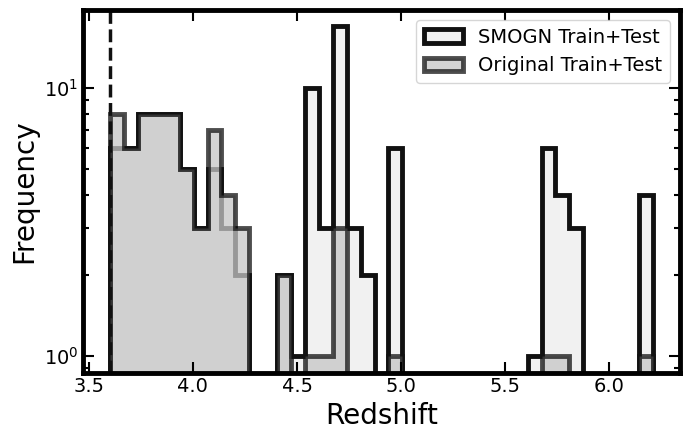

In [42]:
fig             = plt.figure(figsize=(7,4.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_score  = np.nanmin(full_catalog_df.loc[:, 'Z'])
max_score  = np.nanmax(full_catalog_df.loc[:, 'Z'])
score_bins = np.linspace(min_score, max_score, 40)

ax1.hist(train_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.95), alpha=1.0, label='SMOGN Train')
ax1.hist(backup_train_df.loc[:, 'Z'], bins=score_bins, histtype='stepfilled', ec='k',\
         lw=3.5, color=cm.get_cmap('cet_gray')(0.8), alpha=0.75, label='Original Train')

ax1.axvline(x=redshift_low_lim, ls='--', c='k', lw=2.5)
    
ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
ax1.set_xlabel('Redshift', size=20)
ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=14)
plt.grid(False)
# ax1.set_xlim(left=min_score - 1e-2, right=max_score + 1e-2)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()

---

## Use Correlation matrix to discard some features

In [43]:
min_max_scaler              = MinMaxScaler(feature_range=(0., 1.))
full_scaled                 = min_max_scaler.fit_transform(train_test_df.values)
norm_train_test_df = pd.DataFrame(data=full_scaled, columns=train_test_df.columns, index=train_test_df.index)

Calculate Reduced Standard deviation to discard between pairs of features:  

$$\mathrm{RSD} = \frac{\sigma}{\mu} \times 100$$

In [44]:
rsd_vals = (train_test_df.std() / train_test_df.mean() * 100).sort_values(ascending=False)

In [45]:
rsd_vals

w1_w2       35843.105377
z_y           425.851625
i_z           114.287484
r_i            94.133169
g_r            53.340481
g_i            46.884607
w2_w3          22.674179
band_num       18.431223
Z              16.637075
w3_w4          11.686377
J_H             8.546328
H_K             6.891322
rmag            6.580169
r/H             6.486163
gmag            5.665166
g/J             5.563220
imag            5.456160
i/K             5.450657
ymag            4.823030
zmag            4.814086
W1mproPM        4.073805
w1/w4           3.974007
W2mproPM        3.892614
r/z             3.849767
w2/w4           3.752020
z/W1            3.586647
y/W2            3.422781
w1/w3           3.325704
i/y             3.169009
W3mag           1.638622
W4mag           0.553316
Jmag            0.428465
J/K             0.354456
Hmag            0.333414
FUV/K           0.088700
Kmag            0.087865
FUV_NUV        -0.000000
NUVmag          0.000000
FUVmag          0.000000
dtype: float64

In [46]:
correlation = norm_train_test_df.corr()

In [47]:
filt_high_corr = np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [48]:
corr_pairs     = correlation.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_corr]

In [49]:
target_feat = 'Z'

In [50]:
list_drop_corr = []

We want to discard features that are highly correlated (>0.75).  
Between two features, we will discard the one with the lowest standard deviation (RSD).

In [51]:
for row in corr_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_corr:
        continue
    elif row[1] in list_drop_corr:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_corr.append(row[1])
        else:
            list_drop_corr.append(row[0])

In [52]:
list_drop_corr

['i/K',
 'J/K',
 'r/H',
 'Hmag',
 'Jmag',
 'g/J',
 'w1/w4',
 'H_K',
 'w2/w4',
 'zmag',
 'W3mag',
 'r/z',
 'W2mproPM',
 'W1mproPM',
 'i/y',
 'w1/w3',
 'gmag',
 'imag',
 'y/W2',
 'rmag',
 'Kmag']

In [53]:
# correlation.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

In [54]:
norm_train_test_discard = norm_train_test_df.drop(columns=list_drop_corr)

In [55]:
corr_discard = norm_train_test_discard.corr()

In [56]:
corr_discard.abs().unstack().sort_values(ascending=False).drop_duplicates()[:15]

Z         Z           1.000000
FUV/K     J_H         0.784858
Z         i_z         0.762966
ymag      band_num    0.747939
z/W1      z_y         0.747471
ymag      w2_w3       0.737542
g_i       r_i         0.704379
          g_r         0.656044
w1_w2     g_r         0.645087
band_num  Z           0.593722
z/W1      Z           0.593468
w2_w3     w3_w4       0.579271
Z         w1_w2       0.540392
J_H       w3_w4       0.533285
w1_w2     z/W1        0.510684
dtype: float64

Text(1049.9166666666667, 0.5, 'feature')

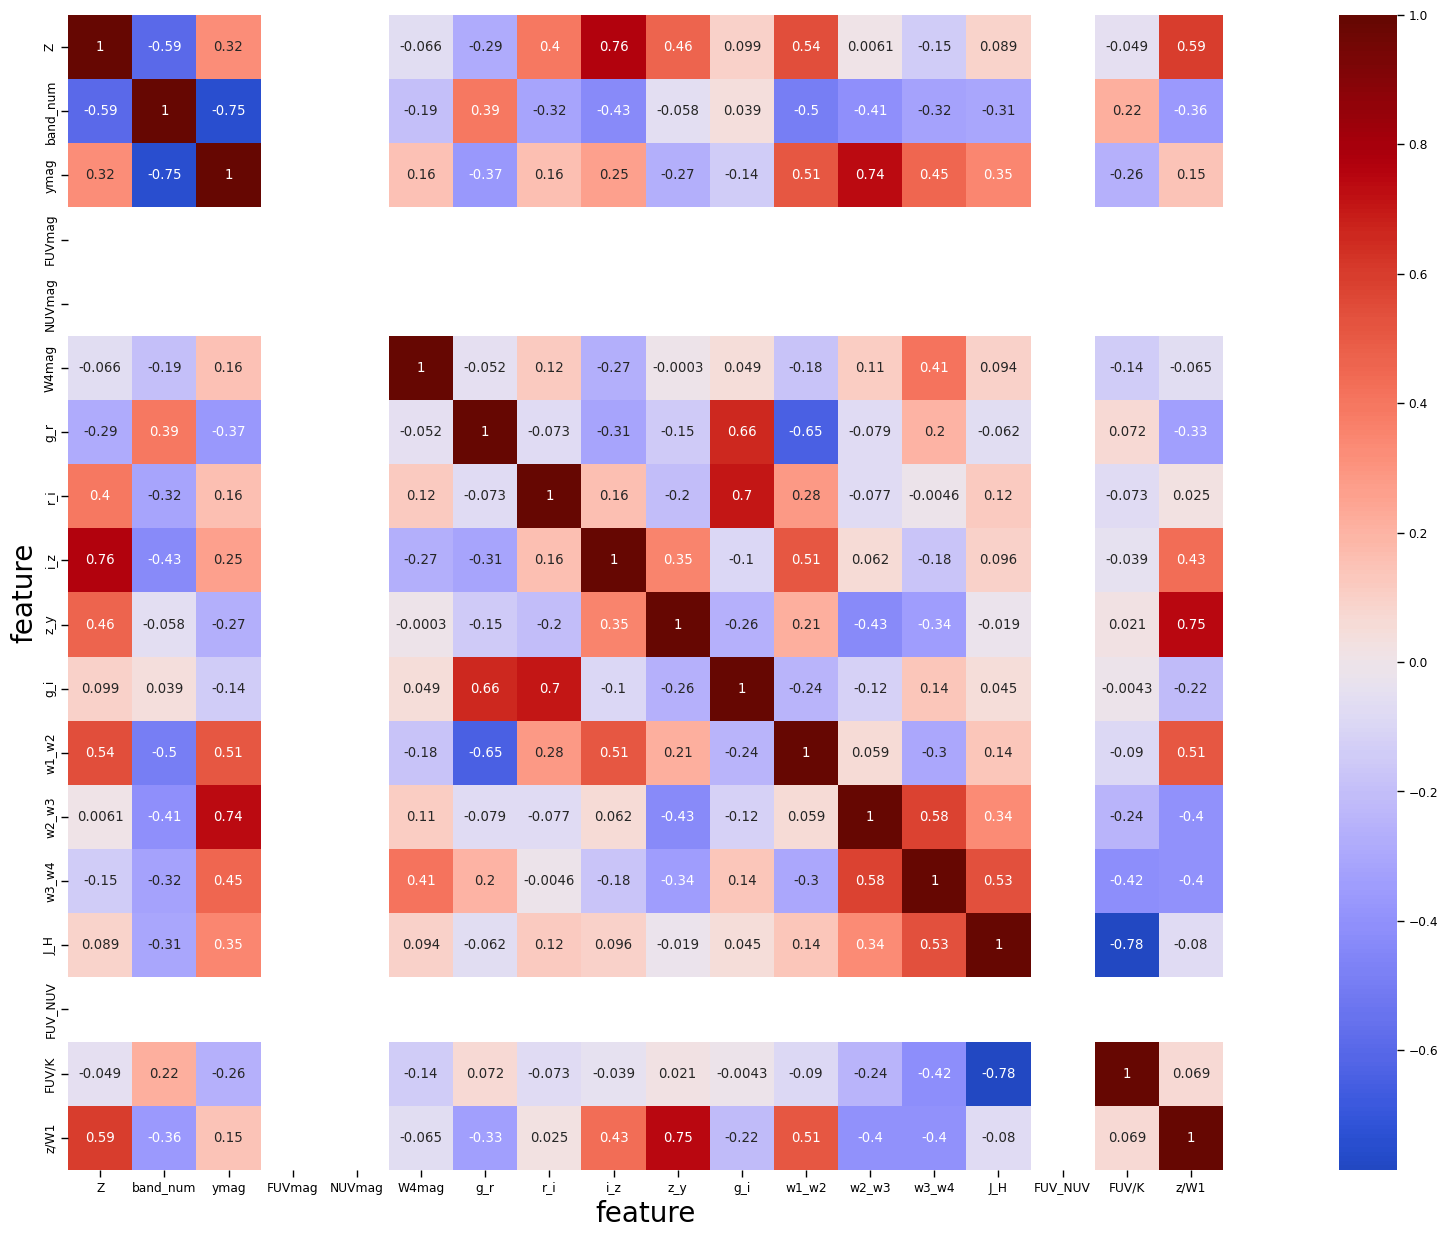

In [57]:
plt.figure(figsize=(30,15))
sns.set_context('paper', rc={'axes.labelsize':20, 'axes.ticklabelsize':14})
ax1 = sns.heatmap(corr_discard, annot=True, cmap=plt.get_cmap('cet_CET_D1A'), center=0.0, square=True)
ax1.set_xlabel('feature')
ax1.set_ylabel('feature')

In [58]:
# norm_train_test_discard.loc[:, 'Z'] = norm_train_test_discard.loc[:, 'Z'].astype(bool)

In [59]:
pps_matrix = pps.matrix(norm_train_test_discard, random_seed=seed)[['x', 'y', 'ppscore']].pivot(columns='x', index='y', values='ppscore')

In [60]:
pps_matrix.unstack().sort_values(ascending=False).drop_duplicates()[:20]

x      y    
FUV/K  FUV/K    1.000000
g_i    r_i      0.825215
       g_r      0.804283
Z      r_i      0.786754
w2_w3  J_H      0.756131
r_i    g_i      0.720133
       Z        0.695099
i_z    Z        0.689882
Z      g_i      0.646808
g_i    Z        0.640305
Z      g_r      0.631327
r_i    g_r      0.585489
i_z    r_i      0.556255
ymag   w3_w4    0.545744
z_y    z/W1     0.545468
w2_w3  w1_w2    0.527876
Z      z/W1     0.520520
i_z    z/W1     0.518602
w2_w3  ymag     0.516281
i_z    g_i      0.496082
dtype: float64

In [61]:
filt_high_pps = np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values > 0.75) &\
np.array(pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().values < 1.00)

In [62]:
pps_pairs     = pps_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().index[filt_high_pps]

In [63]:
target_feat = 'Z'

In [64]:
list_drop_pps = []

In [65]:
for row in pps_pairs:
    if target_feat in row:
        continue
    elif row[0] in list_drop_pps:
        continue
    elif row[1] in list_drop_pps:
        continue
    else:
        metric_a = rsd_vals[row[0]]
        metric_b = rsd_vals[row[1]]
        if metric_a >= metric_b:
            list_drop_pps.append(row[1])
        else:
            list_drop_pps.append(row[0])

In [66]:
list_drop_pps

['g_i', 'J_H']

In [67]:
norm_train_test_discard = norm_train_test_discard.drop(columns=list_drop_pps)

In [68]:
pps_pred_target = pps.predictors(norm_train_test_discard, 'Z', random_seed=seed)

In [69]:
pps_pred_target

,x,y,ppscore,case,is_valid_score,metric,baseline_score,model_score,model
0,r_i,Z,0.695099,regression,True,mean absolute error,0.229518,0.069980,DecisionTreeRegressor()
1,i_z,Z,0.689882,regression,True,mean absolute error,0.229518,0.071178,DecisionTreeRegressor()
2,z/W1,Z,0.408198,regression,True,mean absolute error,0.229518,0.135829,DecisionTreeRegressor()
3,w1_w2,Z,0.391523,regression,True,mean absolute error,0.229518,0.139656,DecisionTreeRegressor()
4,ymag,Z,0.383053,regression,True,mean absolute error,0.229518,0.141601,DecisionTreeRegressor()
5,g_r,Z,0.369423,regression,True,mean absolute error,0.229518,0.144729,DecisionTreeRegressor()
6,w2_w3,Z,0.351844,regression,True,mean absolute error,0.229518,0.148764,DecisionTreeRegressor()
7,band_num,Z,0.320189,regression,True,mean absolute error,0.229518,0.156029,DecisionTreeRegressor()
8,w3_w4,Z,0.310909,regression,True,mean absolute error,0.229518,0.158159,DecisionTreeRegressor()
9,z_y,Z,0.221659,regression,True,mean absolute error,0.229518,0.178643,DecisionTreeRegressor()


---

## Use Machine Learning (ML): PyCaret

## Train Models

### AGN Detection Prediction

In [70]:
final_feats = pps_pred_target.x.to_list()  # Before Boruta
if redshift_low_lim == 3.7:
    final_feats.remove('W4mag')  # After Boruta
    final_feats.remove('FUVmag')  # After Boruta
    final_feats.remove('NUVmag')  # After Boruta
    final_feats.remove('Kmag')  # After Boruta
    final_feats.remove('J_H')  # After Boruta
    final_feats.remove('H_K')  # After Boruta
    final_feats.remove('FUV_NUV')  # After Boruta
elif redshift_low_lim == 3.6:
    final_feats.remove('band_num')  # After Boruta
    final_feats.remove('W4mag')  # After Boruta
    final_feats.remove('FUVmag')  # After Boruta
    final_feats.remove('NUVmag')  # After Boruta
    final_feats.remove('FUV_NUV')  # After Boruta
    final_feats.remove('FUV/K')  # After Boruta

In [71]:
if redshift_low_lim == 3.7:
    feats_2_discard = list_drop_corr + list_drop_pps + ['W4mag', 'FUVmag', 'NUVmag', 'Kmag', 'J_H', 'H_K', 'FUV_NUV']
elif redshift_low_lim == 3.6:
    feats_2_discard = list_drop_corr + list_drop_pps + ['band_num', 'W4mag', 'FUVmag', 'NUVmag', 'FUV_NUV', 'FUV/K']

Boruta discards one feature.

In [72]:
exp_radio = pyr.setup(data=train_df, test_data=test_df, target='Z', session_id=seed, silent=True,\
                    feature_selection=False, feature_selection_method='boruta',\
                    numeric_features=final_feats, ignore_features=feats_2_discard, transformation=True,\
                    transformation_method='yeo-johnson', n_jobs=12, normalize=True,\
                    normalize_method='zscore', use_gpu=False)  # 15 minutes with Boruta # 5 without

,Description,Value
0,session_id,42
1,Target,Z
2,Original Data,"(119, 39)"
3,Missing Values,False
4,Numeric Features,9
5,Categorical Features,0
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(83, 9)"


In [73]:
pyr.get_config('X').columns

Index(['ymag', 'g_r', 'r_i', 'i_z', 'z_y', 'w1_w2', 'w2_w3', 'w3_w4', 'z/W1'], dtype='object')

In [74]:
pyr.models()

,Name,Reference,Turbo
ID,,,
lr,Linear Regression,sklearn.linear_model._base.LinearRegression,True
lasso,Lasso Regression,sklearn.linear_model._coordinate_descent.Lasso,True
ridge,Ridge Regression,sklearn.linear_model._ridge.Ridge,True
en,Elastic Net,sklearn.linear_model._coordinate_descent.Elast...,True
lar,Least Angle Regression,sklearn.linear_model._least_angle.Lars,True
llar,Lasso Least Angle Regression,sklearn.linear_model._least_angle.LassoLars,True
omp,Orthogonal Matching Pursuit,sklearn.linear_model._omp.OrthogonalMatchingPu...,True
br,Bayesian Ridge,sklearn.linear_model._bayes.BayesianRidge,True
ard,Automatic Relevance Determination,sklearn.linear_model._bayes.ARDRegression,False


Add custom metrics

In [75]:
pyr.add_metric('s_mad',  'sigma_mad',    sigma_mad,    greater_is_better=False)
pyr.add_metric('s_nmad', 'sigma_nmad',   sigma_nmad,   greater_is_better=False)
pyr.add_metric('s_z',    'sigma_z',      sigma_z,      greater_is_better=False)
pyr.add_metric('s_z_n',  'sigma_z_norm', sigma_z_norm, greater_is_better=False)
pyr.add_metric('out_f',  'outlier_fr',   outlier_frac, greater_is_better=False)

Name                                                        outlier_fr
Display Name                                                outlier_fr
Score Function               <function outlier_frac at 0x7fdbc64441f0>
Scorer               make_scorer(outlier_frac, greater_is_better=Fa...
Target                                                            pred
Args                                                                {}
Greater is Better                                                False
Custom                                                            True
Name: out_f, dtype: object

In [76]:
metric_2_opt         = 's_mad'
if redshift_low_lim == 3.7:
    final_selection_reg  = ['et', 'gbr' 'rf', 'dt', 'xgboost', 'dummy']
elif redshift_low_lim == 3.6:
    final_selection_reg  = ['xgboost', 'et' 'dt', 'catboost', 'gbr', 'dummy']
n_models             = 5
# top_model_z          = pyr.compare_models(n_select=n_models, include=final_selection_reg, sort=metric_2_opt)  # 1:15 hour for used_models_clf
top_model_z          = pyr.compare_models(n_select=n_models, exclude=['knn'], sort=metric_2_opt)  # 5 minutes, using all models.

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr,TT (Sec)
xgboost,Extreme Gradient Boosting,0.1226,0.0749,0.2143,0.3928,0.0405,0.0304,0.0654,0.0130,0.2143,0.0430,0.0361,2.9270
et,Extra Trees Regressor,0.0983,0.0420,0.1689,0.8705,0.0323,0.0244,0.0696,0.0133,0.1689,0.0340,0.0347,0.0280
dt,Decision Tree Regressor,0.1123,0.0843,0.2058,0.3406,0.0377,0.0276,0.0768,0.0152,0.2058,0.0406,0.0250,0.0090
catboost,CatBoost Regressor,0.1024,0.0318,0.1593,0.8930,0.0304,0.0251,0.0825,0.0156,0.1593,0.0315,0.0125,0.1500
gbr,Gradient Boosting Regressor,0.1152,0.0607,0.1953,0.4500,0.0362,0.0281,0.0870,0.0170,0.1953,0.0384,0.0361,0.0130
rf,Random Forest Regressor,0.1241,0.0647,0.2053,0.5616,0.0382,0.0301,0.0979,0.0171,0.2053,0.0408,0.0361,0.0330
ada,AdaBoost Regressor,0.1063,0.0309,0.1521,0.9284,0.0292,0.0256,0.1040,0.0192,0.1521,0.0300,0.0125,0.0160
lightgbm,Light Gradient Boosting Machine,0.1879,0.0868,0.2597,0.6278,0.0472,0.0437,0.1805,0.0336,0.2597,0.0495,0.0472,2.1070
huber,Huber Regressor,0.3187,0.1523,0.3797,0.0896,0.0708,0.0720,0.4109,0.0725,0.3797,0.0715,0.0486,0.0090
ridge,Ridge Regression,0.3018,0.1281,0.3533,0.4905,0.0643,0.0675,0.4224,0.0747,0.3533,0.0656,0.0125,0.0090


Thus, we select `lightgbm` as meta learner.

Thus, we stack the models.

In [77]:
stacked_model_z = pyr.stack_models(estimator_list=top_model_z[1:], meta_model=top_model_z[0],\
                                   optimize=metric_2_opt, restack=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1152,0.0262,0.1619,0.9289,0.0323,0.0286,0.0965,0.0198,0.1619,0.0327,0.0000
1,0.0568,0.0093,0.0962,0.9853,0.0191,0.0136,0.0383,0.0053,0.0962,0.0195,0.0000
2,0.1299,0.0300,0.1731,0.9335,0.0341,0.0323,0.2171,0.0428,0.1731,0.0350,0.0000
3,0.0646,0.0098,0.0992,0.9482,0.0199,0.0149,0.0517,0.0090,0.0992,0.0195,0.0000
4,0.0606,0.0053,0.0729,0.9931,0.0147,0.0150,0.0772,0.0150,0.0729,0.0149,0.0000
5,0.1545,0.0599,0.2447,0.9378,0.0484,0.0375,0.1396,0.0284,0.2447,0.0466,0.0000
6,0.1563,0.1302,0.3608,0.8054,0.0670,0.0401,0.0606,0.0123,0.3608,0.0736,0.1250
7,0.0406,0.0038,0.0615,0.9918,0.0120,0.0093,0.0287,0.0047,0.0615,0.0121,0.0000
8,0.1089,0.0219,0.1481,0.5586,0.0289,0.0264,0.0868,0.0180,0.1481,0.0287,0.0000


In [78]:
tuned_z_reg = pyr.tune_model(stacked_model_z, early_stopping='asha', optimize=metric_2_opt,\
                             search_library='tune-sklearn', search_algorithm='random')  # 1h30

,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
Fold,,,,,,,,,,,
0,0.1613,0.0561,0.2368,0.8478,0.0473,0.0400,0.0603,0.0103,0.2368,0.0478,0.0000
1,0.0668,0.0095,0.0975,0.9850,0.0195,0.0160,0.0391,0.0061,0.0975,0.0199,0.0000
2,0.1478,0.0642,0.2533,0.8576,0.0498,0.0376,0.0866,0.0170,0.2533,0.0529,0.0000
3,0.0534,0.0047,0.0687,0.9752,0.0133,0.0119,0.0614,0.0100,0.0687,0.0131,0.0000
4,0.0372,0.0023,0.0474,0.9971,0.0094,0.0092,0.0483,0.0101,0.0474,0.0095,0.0000
5,0.1599,0.0643,0.2536,0.9332,0.0501,0.0387,0.1165,0.0237,0.2536,0.0485,0.0000
6,0.1668,0.0973,0.3119,0.8546,0.0591,0.0429,0.0993,0.0206,0.3119,0.0637,0.1250
7,0.0295,0.0017,0.0410,0.9964,0.0079,0.0067,0.0214,0.0034,0.0410,0.0079,0.0000
8,0.1102,0.0265,0.1629,0.4663,0.0329,0.0271,0.1031,0.0210,0.1629,0.0319,0.0000


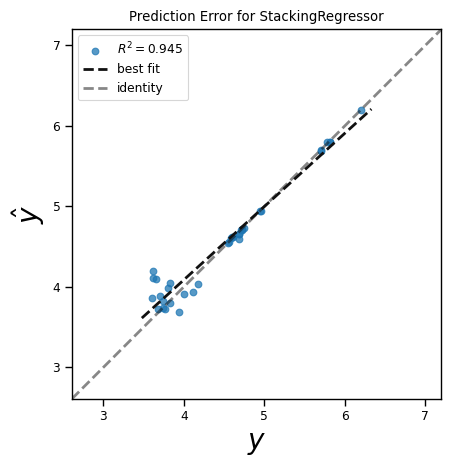

In [79]:
pyr.plot_model(tuned_z_reg, plot='error')

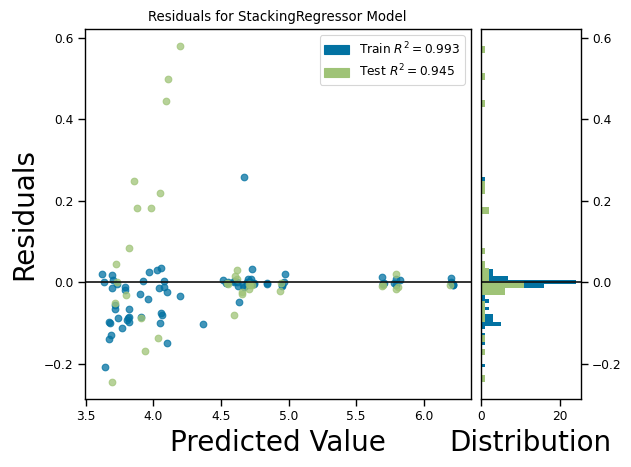

In [80]:
pyr.plot_model(tuned_z_reg, plot='residuals')

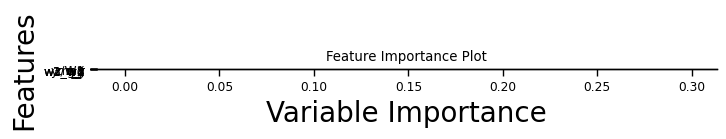

In [81]:
pyr.plot_model(tuned_z_reg.estimators_[0], plot='feature_all')

In [82]:
pyr.plot_model(tuned_z_reg.final_estimator, plot='parameter')

,Parameters
objective,reg:squarederror
base_score,0.5
booster,gbtree
colsample_bylevel,1
colsample_bynode,1
colsample_bytree,0.7
enable_categorical,False
gamma,0
gpu_id,-1
importance_type,None


In [83]:
plt.rcParams.update(plt.rcParamsDefault)

In [84]:
pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0978,0.0304,0.1743,0.9451,0.0357,0.0256,0.0388,0.0068,0.1743,0.0372,0.0000


,ymag,g_r,r_i,i_z,z_y,w1_w2,w2_w3,w3_w4,z/W1,Z,Label
0,-0.471246,-0.540073,-0.470443,-0.852714,0.078241,0.135389,-0.507934,0.516598,-0.405404,4.000000,3.913399
1,0.013458,-0.800225,-1.165033,-0.920749,1.209868,0.058998,0.287895,0.516598,0.604975,3.701000,3.881833
2,-0.460776,0.175468,0.263064,-0.278014,-0.342805,-1.275726,-0.113736,0.382066,-0.745698,4.543724,4.542876
3,-0.185742,-1.581073,1.356713,0.998320,2.401482,1.845891,-1.626576,-2.007542,1.960174,5.776715,5.795785
4,0.098472,1.311384,1.019669,-1.237699,-0.281960,-0.068410,-0.509998,0.447237,0.367771,4.741865,4.733782
5,0.133012,-0.279798,-0.618899,-0.456211,-0.043977,1.030198,0.327007,0.516598,-0.837307,3.652000,4.096828
6,0.743779,-0.640330,-0.866448,-1.116169,-0.648264,0.237647,0.005397,0.516598,0.519066,3.607000,3.855051
7,1.515202,-1.597086,1.943382,-0.019744,-2.473318,1.208431,1.298448,0.313164,-1.354343,4.592960,4.622982
8,-1.647761,-0.371322,-0.872413,-0.424393,-0.165033,-0.758882,-1.601458,-1.978129,0.038857,3.833000,3.802419
9,-0.106305,-0.045169,-0.753598,-0.457768,-0.202004,1.037305,-0.014429,0.516598,-1.202831,3.612000,4.109505


In [85]:
test_prediction_reg = pyr.predict_model(tuned_z_reg)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0978,0.0304,0.1743,0.9451,0.0357,0.0256,0.0388,0.0068,0.1743,0.0372,0.0000


In [86]:
final_z_reg = pyr.finalize_model(tuned_z_reg)

In [87]:
if save_model_flag:
    if redshift_low_lim == 3.7:
        pyr.save_model(final_z_reg, 'models/regression_z_jun_01_2022')  # Model (it will be saved with .pkl extension)
        # pyr.save_config('models/config_regression_z_jun_01_2022')  # Configuration file
    elif redshift_low_lim == 3.6:
        pyr.save_model(final_z_reg, 'models/regression_z_jul_19_2022')  # Model (it will be saved with .pkl extension)
        # pyr.save_config('models/config_regression_z_jul_19_2022')  # Configuration file

Transformation Pipeline and Model Successfully Saved


## Load Models

AGN detection model.

In [70]:
if load_model_flag:
    if redshift_low_lim == 3.7:
        final_z_reg = pyr.load_model('models/regression_z_jun_01_2022')  # for z >= 4, regression_z_may_31_4_2022
    elif redshift_low_lim == 3.6:
        final_z_reg = pyr.load_model('models/regression_z_jul_19_2022')  # for z >= 4, regression_z_may_31_4_2022

Transformation Pipeline and Model Successfully Loaded


### Prediction process

#### Feature importances

In [88]:
estimators_list = get_base_estimators_names(final_z_reg)

In [89]:
extended_data_z = validation_df.loc[:, get_final_column_names(final_z_reg, validation_df)].copy()
extended_idx_z  = extended_data_z.index
initial_cols_z  = extended_data_z.columns
extended_cols_z = extended_data_z.columns.insert(0, estimators_list[0])
if len(estimators_list) > 1:
    for est_name in estimators_list[1::]:
        extended_cols_z = extended_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [90]:
print('Running data pre-processing:\n')
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    prep_steps = final_z_reg.named_steps.items()
else:
    prep_steps = pyr.get_config('prep_pipe').named_steps.items()

for (name, method) in prep_steps:
    if method != 'passthrough':  # and name != 'trained_model':
        print(f'Running {name}')
        extended_data_z = method.transform(extended_data_z)
extended_data_z_df = pd.DataFrame(extended_data_z, columns=extended_cols_z, index=extended_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [91]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    if hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.named_steps['trained_model'].final_estimator_.feature_importances_
    elif hasattr(final_z_reg.named_steps['trained_model'].final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.named_steps['trained_model'].final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)
else:
    if hasattr(final_z_reg.final_estimator_, 'feature_importances_'):
        importances_coef = final_z_reg.final_estimator_.feature_importances_
    elif hasattr(final_z_reg.final_estimator_, 'coef_'):
        importances_coef = np.abs(np.ravel(final_z_reg.final_estimator_.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z].std(axis=0)

coef_meta_df = pd.DataFrame({'Feature': extended_cols_z, 'Importance': importances_coef})
coef_sorted_meta_df = (
    coef_meta_df.sort_values(by='Importance', ascending=False)
    .head(len(extended_cols_z))
    .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [92]:
if isinstance(final_z_reg, sklearn.pipeline.Pipeline):
    estimators_list  = final_z_reg.named_steps['trained_model'].estimators
    estimators_list_ = final_z_reg.named_steps['trained_model'].estimators_
else:
    estimators_list  = final_z_reg.estimators
    estimators_list_ = final_z_reg.estimators_

In [93]:
base_models_names = [model[0] for model in estimators_list]

In [94]:
coef_sorted_base_df = {}

In [95]:
for model, model_fit in zip(base_models_names, estimators_list_):
    if hasattr(model_fit, 'feature_importances_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': model_fit.feature_importances_})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_z.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
    )
    elif hasattr(model_fit, 'coef_'):
        coef_base_df = pd.DataFrame({'Feature': extended_cols_z.drop(base_models_names),
                                     'Importance': np.abs(np.ravel(model_fit.coef_)) *\
                                     extended_data_z_df.loc[:, extended_cols_z.drop(base_models_names)].std(axis=0)})
        coef_sorted_base_df[model] = (
        coef_base_df.sort_values(by='Importance', ascending=False)
        .head(len(extended_cols_radio.drop(base_models_names)))
        .sort_values(by='Importance', ascending=False).reset_index(drop=True)
)

In [96]:
multicol_feat = [(key, name) for key in coef_sorted_base_df.keys() for name in ('Feature', 'Importance')]

In [97]:
print('Feature importances scaled to sum 100')
coef_sorted_base_df_copy_sum = coef_sorted_base_df.copy()
for key in coef_sorted_base_df_copy_sum.keys():
    print(f'Calculating for {key}...')
    coef_sorted_base_df_copy_sum[key].loc[:, 'Importance'] = coef_sorted_base_df[key].loc[:, 'Importance'] /\
                                                        coef_sorted_base_df[key].loc[:, 'Importance'].sum() * 100
    # display(coef_sorted_base_df_copy_sum[key])
coef_sorted_base_full_df = pd.concat([coef_sorted_base_df_copy_sum[key].reset_index(drop=True) for key in coef_sorted_base_df_copy_sum.keys()], axis=1)
coef_sorted_base_full_df.columns = pd.MultiIndex.from_tuples(multicol_feat)
display(coef_sorted_base_full_df)

Feature importances scaled to sum 100
Calculating for et...
Calculating for dt...
Calculating for catboost...
Calculating for gbr...


et                 dt            catboost                gbr           
  Feature Importance Feature Importance  Feature Importance Feature Importance
0     i_z  29.046446     i_z  62.161853      i_z  29.362151     i_z  62.217421
1     r_i  22.306928     r_i  24.857051      r_i  26.720730     r_i  24.655207
2     g_r  11.151399     g_r  10.672517      g_r  13.040656     g_r   6.153391
3     z_y  11.030223   w1_w2   1.641176     z/W1   9.595832    z/W1   4.912498
4    z/W1  10.760078    ymag   0.252748      z_y   6.467115    ymag   0.796223
5   w1_w2   7.939859    z/W1   0.195427    w1_w2   5.439570   w1_w2   0.580265
6   w3_w4   5.010300     z_y   0.127549    w3_w4   3.560490   w2_w3   0.474946
7    ymag   1.731388   w2_w3   0.089658    w2_w3   3.009944     z_y   0.207285
8   w2_w3   1.023378   w3_w4   0.002020     ymag   2.803512   w3_w4   0.002764

In [98]:
print('Feature importances scaled to sum 100')
coef_sorted_meta_df_copy_sum = coef_sorted_meta_df.copy()
coef_sorted_meta_df_copy_sum.loc[:, 'Importance'] = coef_sorted_meta_df.loc[:, 'Importance'] /\
                                                     coef_sorted_meta_df.loc[:, 'Importance'].sum() * 100
print('Meta model')
display(coef_sorted_meta_df_copy_sum)

Feature importances scaled to sum 100
Meta model


,Feature,Importance
0,catboost,29.177380
1,dt,28.070375
2,gbr,21.422155
3,et,14.574236
4,i_z,2.145884
5,r_i,1.146741
6,z_y,0.749679
7,ymag,0.671285
8,g_r,0.531442
9,w1_w2,0.509123


Feature importances scaled to sum 100
Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
--------------------
top features:
Feature	Importance
i_z	29.997
r_i	26.640
g_r	12.932
z/W1	9.470
z_y	6.389
w1_w2	5.380
w3_w4	3.505
w2_w3	2.938
ymag	2.749


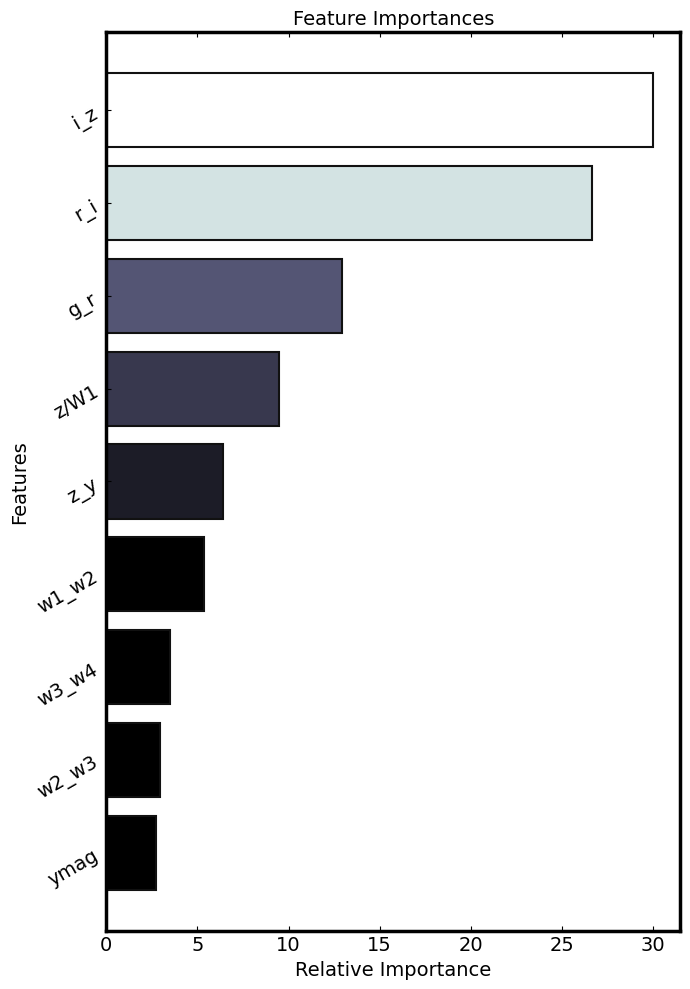

In [123]:
print('Feature importances scaled to sum 100')
try:
    fig         = plt.figure(figsize=(7,10))
    ax1         = fig.add_subplot(111)
    n_top       = len(validation_df.columns)
    features_df = get_feature_importances_df(final_z_reg, validation_df, n=n_top)
    features    = features_df.loc[:, 'Feature'].to_list()
    importances = features_df.loc[:, 'Importance'].to_list()
    import_scal = importances / np.nansum(importances)
    import_scal_colors = (importances - np.nanmin(importances)) / (np.nanmax(importances) - np.nanmin(importances))
    # indices     = np.argsort(importances)[-n_top:] #only show most important features
    # indices     = np.argsort(importances)
    # ax1.set_title(f'{model_name} Feature Importances', size=14)
    ax1.set_title('Feature Importances', size=14)
    ax1.barh(range(len(importances)), import_scal * 100,\
             color=plt.get_cmap('bone', len(importances))(import_scal_colors), align='center', ec='k', lw=1.5)
    # plt.yticks(range(len(importances)), [features[i] for i in importances])
    plt.yticks(range(len(importances)), features)
    ax1.set_xlabel('Relative Importance', size=14)
    ax1.set_ylabel('Features', size=14)
    ax1.tick_params(axis='both', which='major', labelsize=14)
    ax1.tick_params(axis='y', which='major', rotation=30)
    plt.setp(ax1.spines.values(), linewidth=2.5)
    ax1.tick_params(which='both',top=True, right=False, direction='in')
    # ax1.set_xscale('log')
    # plt.show()
    plt.tight_layout()
    if save_plot_flag:
        if redshift_low_lim == 3.7:
            plt.savefig('plots/feat_imp_regression_z_08.pdf', bbox_inches='tight')
        elif redshift_low_lim == 3.6:
            plt.savefig('plots/feat_imp_regression_z_09.pdf', bbox_inches='tight')

    print('-' * 20)
    print('top features:')
    print('Feature\tImportance')
    for feat, imp in zip(reversed(features), reversed(import_scal  * 100)):
        print(f'{feat}\t{round(imp, 3):>.3f}')

except:
    print('learning algorithm does not provide feature importance.')

In [124]:
validation_prediction_reg = pyr.predict_model(final_z_reg, data=validation_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.2658,0.1387,0.3725,0.3427,0.0705,0.0606,0.2672,0.0569,0.3725,0.0665,0.0556


In [125]:
validation_prediction_reg.loc[:, ['Z', 'Label']].describe()

,Z,Label
count,18.000000,18.000000
mean,4.106167,3.941846
std,0.472725,0.262318
min,3.612000,3.572991
25%,3.675250,3.819198
50%,3.917000,3.865333
75%,4.531000,4.013038
max,5.000000,4.672462


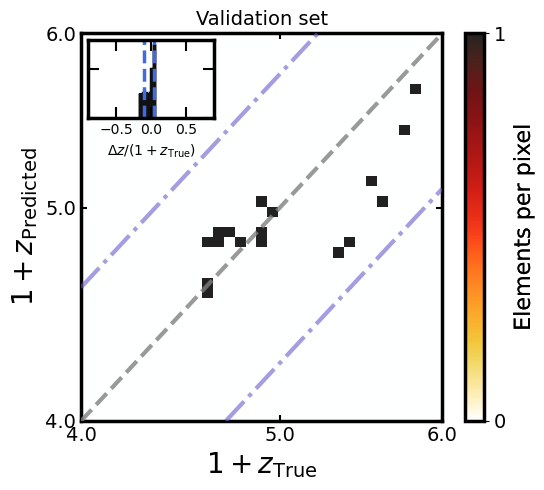

In [127]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Validation set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    if redshift_low_lim == 3.7:
        plt.savefig('plots/compare_plot_validation_redshift_08.pdf', bbox_inches='tight')
    elif redshift_low_lim == 3.6:
        plt.savefig('plots/compare_plot_validation_redshift_09.pdf', bbox_inches='tight')
plt.show()

In [128]:
train_size         = 0.7
data_split_shuffle = True
_stratify_columns  = _get_columns_to_stratify_by(
            backup_train_test_df.drop(columns=['Z']), backup_train_test_df.loc[:, 'Z'], False, 'Z'
        )

X_train, X_test, y_train, y_test = train_test_split(
                backup_train_test_df.drop(columns=['Z']),
                backup_train_test_df.loc[:, 'Z'],
                test_size=1 - train_size,
                stratify=_stratify_columns,
                random_state=seed,
                shuffle=data_split_shuffle,
            )
train_df        = pd.concat([X_train, y_train], axis=1)
test_df         = pd.concat([X_test, y_test], axis=1)

In [129]:
train_prediction_reg      = pyr.predict_model(final_z_reg, data=train_df)
test_prediction_reg       = pyr.predict_model(final_z_reg, data=test_df)
train_test_prediction_reg = pyr.predict_model(final_z_reg, data=train_test_df)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0563,0.0084,0.0917,0.9731,0.0182,0.0139,0.0420,0.0084,0.0917,0.0179,0.0000


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.1601,0.0739,0.2718,-0.0528,0.0545,0.0407,0.1075,0.0218,0.2718,0.0557,0.0455


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,sigma_mad,sigma_nmad,sigma_z,sigma_z_norm,outlier_fr
0,Stacking Regressor,0.0496,0.0098,0.0992,0.9826,0.0197,0.0118,0.0298,0.0062,0.0992,0.0189,0.0000


In [130]:
sigma_mad_train         = sigma_mad(train_prediction_reg.loc[:, 'Z'],         train_prediction_reg.loc[:, 'Label'])
sigma_mad_test          = sigma_mad(test_prediction_reg.loc[:, 'Z'],          test_prediction_reg.loc[:, 'Label'])
sigma_mad_train_test    = sigma_mad(train_test_prediction_reg.loc[:, 'Z'],    train_test_prediction_reg.loc[:, 'Label'])
sigma_mad_valid         = sigma_mad(validation_prediction_reg.loc[:, 'Z'],    validation_prediction_reg.loc[:, 'Label'])

In [131]:
sigma_nmad_train        = sigma_nmad(train_prediction_reg.loc[:, 'Z'],        train_prediction_reg.loc[:, 'Label'])
sigma_nmad_test         = sigma_nmad(test_prediction_reg.loc[:, 'Z'],         test_prediction_reg.loc[:, 'Label'])
sigma_nmad_train_test   = sigma_nmad(train_test_prediction_reg.loc[:, 'Z'],   train_test_prediction_reg.loc[:, 'Label'])
sigma_nmad_valid        = sigma_nmad(validation_prediction_reg.loc[:, 'Z'],   validation_prediction_reg.loc[:, 'Label'])

In [132]:
sigma_z_train           = sigma_z(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
sigma_z_test            = sigma_z(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
sigma_z_train_test      = sigma_z(train_test_prediction_reg.loc[:, 'Z'],      train_test_prediction_reg.loc[:, 'Label'])
sigma_z_valid           = sigma_z(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [133]:
sigma_z_norm_train      = sigma_z_norm(train_prediction_reg.loc[:, 'Z'],      train_prediction_reg.loc[:, 'Label'])
sigma_z_norm_test       = sigma_z_norm(test_prediction_reg.loc[:, 'Z'],       test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_train_test = sigma_z_norm(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'])
sigma_z_norm_valid      = sigma_z_norm(validation_prediction_reg.loc[:, 'Z'], validation_prediction_reg.loc[:, 'Label'])

In [134]:
out_frac_train      = outlier_frac(train_prediction_reg.loc[:, 'Z'],           train_prediction_reg.loc[:, 'Label'])
out_frac_test       = outlier_frac(test_prediction_reg.loc[:, 'Z'],            test_prediction_reg.loc[:, 'Label'])
out_frac_train_test = outlier_frac(train_test_prediction_reg.loc[:, 'Z'],      train_test_prediction_reg.loc[:, 'Label'])
out_frac_valid      = outlier_frac(validation_prediction_reg.loc[:, 'Z'],      validation_prediction_reg.loc[:, 'Label'])

In [135]:
print('Scores for training set:')
print(f'Sigma MAD:\t\t{sigma_mad_train:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train:.4f}')
print(f'Sigma z:\t\t{sigma_z_train:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train:.4f}')
print(f'Out fraction:\t\t{out_frac_train:.4f}')
print('-' * 35)

Scores for training set:
Sigma MAD:		0.0420
Sigma NMAD:		0.0084
Sigma z:		0.0917
Sigma z norm:		0.0179
Out fraction:		0.0000
-----------------------------------


In [136]:
print('Scores for test set:')
print(f'Sigma MAD:\t\t{sigma_mad_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_test:.4f}')
print(f'Out fraction:\t\t{out_frac_test:.4f}')
print('-' * 35)

Scores for test set:
Sigma MAD:		0.1075
Sigma NMAD:		0.0218
Sigma z:		0.2718
Sigma z norm:		0.0557
Out fraction:		0.0455
-----------------------------------


In [137]:
print('Scores for training+test set:')
print(f'Sigma MAD:\t\t{sigma_mad_train_test:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_train_test:.4f}')
print(f'Sigma z:\t\t{sigma_z_train_test:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_train_test:.4f}')
print(f'Out fraction:\t\t{out_frac_train_test:.4f}')
print('-' * 35)

Scores for training+test set:
Sigma MAD:		0.0298
Sigma NMAD:		0.0062
Sigma z:		0.0992
Sigma z norm:		0.0189
Out fraction:		0.0000
-----------------------------------


In [138]:
print('Scores for validation set:')
print(f'Sigma MAD:\t\t{sigma_mad_valid:.4f}')
print(f'Sigma NMAD:\t\t{sigma_nmad_valid:.4f}')
print(f'Sigma z:\t\t{sigma_z_valid:.4f}')
print(f'Sigma z norm:\t\t{sigma_z_norm_valid:.4f}')
print(f'Out fraction:\t\t{out_frac_valid:.4f}')
print('-' * 35)

Scores for validation set:
Sigma MAD:		0.2672
Sigma NMAD:		0.0569
Sigma z:		0.3725
Sigma z norm:		0.0665
Out fraction:		0.0556
-----------------------------------


Display metrics as DataFrame

In [139]:
metrics_z = np.array([[sigma_mad_train,      sigma_nmad_train,      sigma_z_train,      sigma_z_norm_train,      out_frac_train],\
                      [sigma_mad_test,       sigma_nmad_test,       sigma_z_test,       sigma_z_norm_test,       out_frac_test],\
                      [sigma_mad_train_test, sigma_nmad_train_test, sigma_z_train_test, sigma_z_norm_train_test, out_frac_train_test],\
                      [sigma_mad_valid,      sigma_nmad_valid,      sigma_z_valid,      sigma_z_norm_valid,      out_frac_valid]])

In [140]:
metrics_z_df = pd.DataFrame(data=metrics_z, index=['Train', 'Test', 'Train+Test', 'Validation'],\
                            columns=['\u03C3 MAD', '\u03C3 NMAD', '\u03C3 z', '\u03C3 z N', '\u03B7'])

In [141]:
with pd.option_context('display.float_format', '{:.4f}'.format):
    display(metrics_z_df)

,σ MAD,σ NMAD,σ z,σ z N,η
Train,0.0420,0.0084,0.0917,0.0179,0.0000
Test,0.1075,0.0218,0.2718,0.0557,0.0455
Train+Test,0.0298,0.0062,0.0992,0.0189,0.0000
Validation,0.2672,0.0569,0.3725,0.0665,0.0556


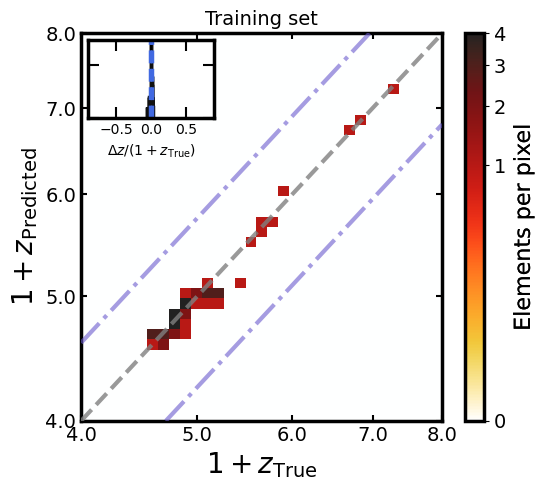

In [142]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(train_prediction_reg.loc[:, 'Z'], train_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Training set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    if redshift_low_lim == 3.7:
        plt.savefig('plots/compare_plot_train_redshift_08.pdf', bbox_inches='tight')
    elif redshift_low_lim == 3.6:
        plt.savefig('plots/compare_plot_train_redshift_09.pdf', bbox_inches='tight')
plt.show()

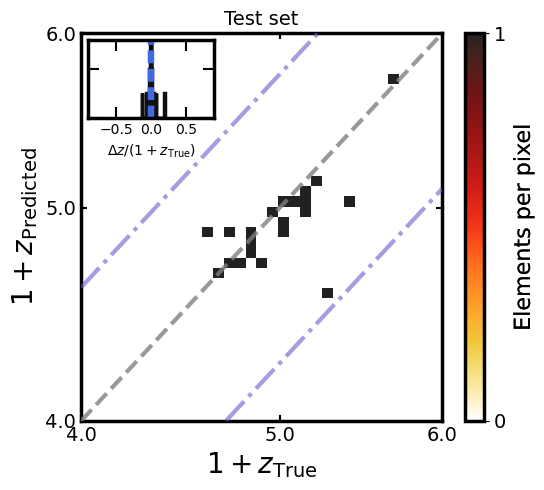

In [143]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(test_prediction_reg.loc[:, 'Z'], test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    if redshift_low_lim == 3.7:
        plt.savefig('plots/compare_plot_test_redshift_08.pdf', bbox_inches='tight')
    elif redshift_low_lim == 3.6:
        plt.savefig('plots/compare_plot_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

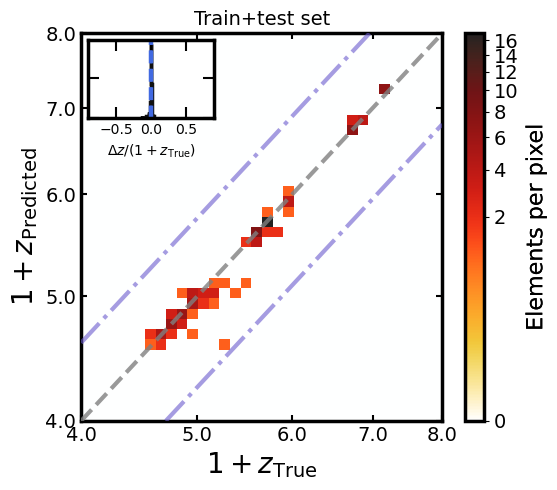

In [144]:
fig             = plt.figure(figsize=(6,5))
ax1             = fig.add_subplot(111, projection='scatter_density', xscale='log', yscale='log')
plot_redshift_compare(train_test_prediction_reg.loc[:, 'Z'], train_test_prediction_reg.loc[:, 'Label'],\
                      ax_pre=ax1, title='Train+test set', dpi=10, show_clb=True, log_stretch=False)
if save_plot_flag:
    if redshift_low_lim == 3.7:
        plt.savefig('plots/compare_plot_train_test_redshift_08.pdf', bbox_inches='tight')
    elif redshift_low_lim == 3.6:
        plt.savefig('plots/compare_plot_train_test_redshift_09.pdf', bbox_inches='tight')
plt.show()

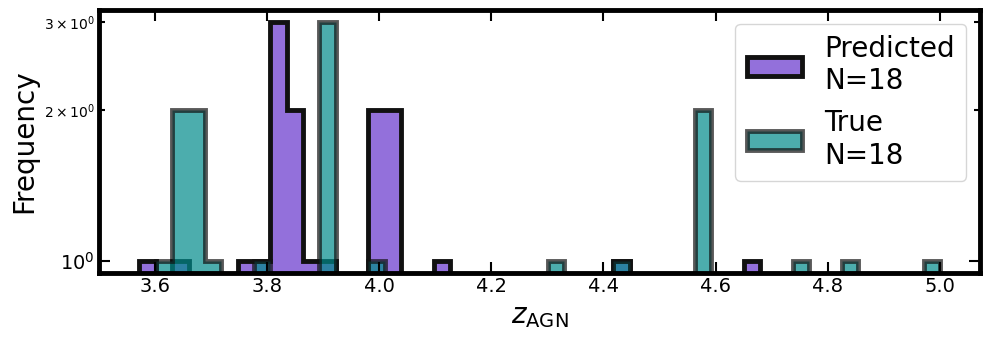

In [145]:
fig             = plt.figure(figsize=(10,3.5))
ax1             = fig.add_subplot(111, xscale='linear', yscale='log')

min_for_range = np.nanmin([np.nanmin(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmin(validation_prediction_reg.loc[:, 'Label'])])
max_for_range = np.nanmax([np.nanmax(validation_prediction_reg.loc[:, 'Z']),\
                           np.nanmax(validation_prediction_reg.loc[:, 'Label'])])
bins_z        = np.linspace(min_for_range, max_for_range, 50)

_, bins, _ = ax1.hist(validation_prediction_reg.loc[:, 'Label'], bins=bins_z, histtype='stepfilled',\
                      ec='k', fc='mediumpurple', lw=3.5,\
                      label=f"Predicted\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Label'] > 0))}")
ax1.hist(validation_prediction_reg.loc[:, 'Z'], bins=bins_z, histtype='stepfilled', ec='k', fc='darkcyan',\
         lw=3.5, label=f"True\nN={np.sum(np.array(validation_prediction_reg.loc[:, 'Z'] > 0))}", alpha=0.7)

ax1.tick_params(which='both', top=True, right=True, direction='in')
ax1.tick_params(axis='both', which='major', labelsize=14)
ax1.tick_params(which='major', length=8, width=1.5)
ax1.tick_params(which='minor', length=4, width=1.5)
# ax1.set_xlabel('$m_{\mathrm{W1}}\, \mathrm{[AB]}$', size=20)
ax1.set_xlabel('$z_{\mathrm{AGN}}$', size=20)
ax1.set_ylabel('Frequency', size=20)
# ax1.set_ylabel('Frequency', size=20)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.setp(ax1.spines.values(), linewidth=3.5)
plt.legend(loc=1, fontsize=20)
# ax1.invert_xaxis()
# ax1.set_xlim(left=-4, right=6)
#ax1.set_aspect('equal', 'box')
fig.tight_layout()
if save_plot_flag:
    if redshift_low_lim == 3.7:
        plt.savefig('plots/hist_true_predicted_z_08.pdf')
    elif redshift_low_lim == 3.6:
        plt.savefig('plots/hist_true_predicted_z_09.pdf')
plt.show()